In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat

from math import sqrt

import numpy as np
from numpy import concatenate

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras

from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import *
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras import optimizers

K = tf.keras.backend

import math
import matplotlib.pyplot as plt

import random

In [2]:
def series_to_supervised(data, time_steps=1, shift=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(time_steps, 0, -1):
        cols.append(df.shift(i))
        names += [('var(%dt-%d)' % (j+1, i)) for j in range(n_vars)]
        
    cols.append(df.shift(1-shift))
    names += [('var(t)')]
    
    agg = concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def takeSlice(arr, fr, to, name):
    result = arr[:,fr:to,:]
    print(name + ": start at " + str(fr) + " - shape: " + str(result.shape))
    return result

In [4]:
def moving_average(series, n=3) :
    rolling = series.rolling(window=n)
    rolling_mean = rolling.mean()
    return rolling_mean

## load data

In [5]:
sales_df = pd.read_csv('D:/GDP_Lab/StoreItemDemanForecasting/Data/train.csv')
sales_df["date"] = pd.to_datetime(sales_df["date"])
ind_sales_data = sales_df.set_index(["date"], drop=True)
ind_sales_data.head()

store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10

In [6]:
stores_items_df = ind_sales_data.copy()
store_ids = [s for s in range(1, 11)]
item_ids = [i for i in range(1, 51)]
cluster_id = 1
df = []

for it in item_ids:
    for st in store_ids:
        dr = stores_items_df[stores_items_df.store == st]
        dr = dr[dr.item == it]
        dr = dr[['sales']]
        if(len(dr) > 0):
            df.append(dr)

## differencing

In [7]:
sales_series = list()

for dataF in df:
    sales_series.append(dataF.values)

sales_series = np.array(sales_series)

true_data = sales_series.reshape((sales_series.shape[0], sales_series.shape[1]))
true_dataLength = true_data.shape[1]
print(sales_series.shape)
print(true_data.shape)

(500, 1826, 1)
(500, 1826)


In [8]:
days_in_year = 365
series_diff = list()

for i, series in enumerate(sales_series):
#     print("Series:", i)
    diff = list()
    for j in range(days_in_year, len(series)):
        subst = 0
        thn = df[i].index[j].year
        bln = df[i].index[j].month
#         print(thn, bln, hari)
        month_str = str(thn-1)+'-'+str(bln)
        subst = df[i][month_str].mean()
        value = series[j] - subst
        diff.append(value)
    series_diff.append(diff)

In [9]:
series_diff = np.array(series_diff)
print(series_diff.shape)

nPredict = 90
totalLength = series_diff.shape[1]
nseries = series_diff.shape[0]
shift = nPredict

data = series_diff.reshape((nseries, totalLength))
print(data.shape)

(500, 1461, 1)
(500, 1461)


## prepare data

(1461, 500)


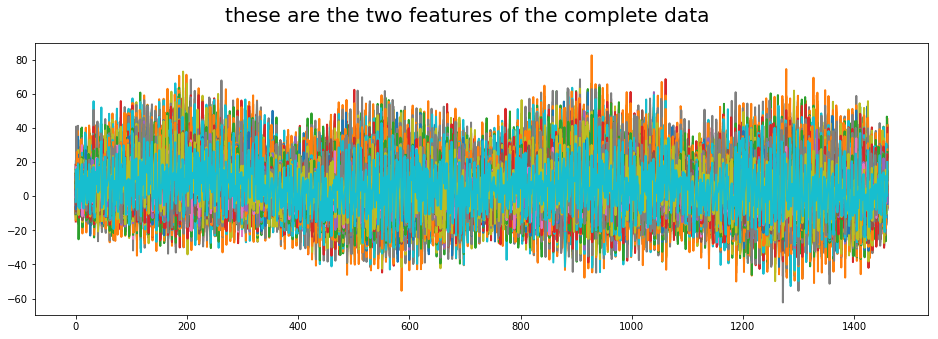

data:  (1461, 500)


In [10]:
reshape_data = np.zeros((data.shape[1], data.shape[0]))
print(reshape_data.shape)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,5))
for i in range(nseries):
    ax.plot(range(totalLength),data[i],linewidth=2)
fig.suptitle('these are the two features of the complete data',fontsize=20)
plt.show()

for i in range(data.shape[0]):
    reshape_data[:,i] = data[i]

print('data: ', reshape_data.shape)

In [11]:
scaler = MinMaxScaler()
reshape_data = scaler.fit_transform(reshape_data)

print(reshape_data.shape)

(1461, 500)


(500, 1461, 1)


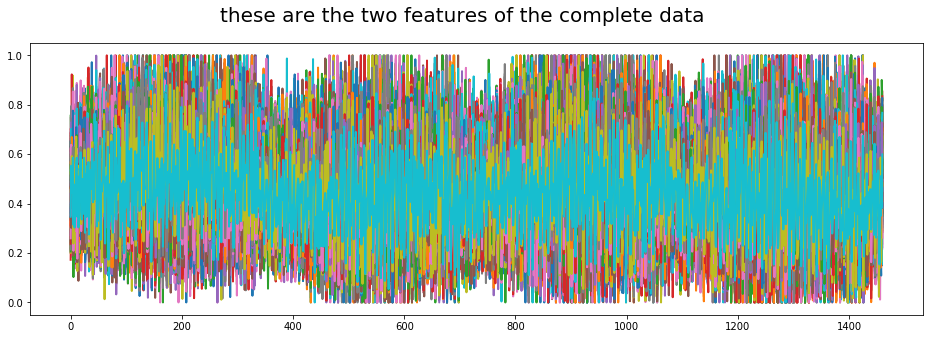

In [12]:
learning_data = np.zeros((data.shape[0], data.shape[1]))
for i in range(data.shape[0]):
    learning_data[i] = reshape_data[:,i]

learning_data = learning_data.reshape((learning_data.shape[0], learning_data.shape[1], 1))
print(learning_data.shape)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,5))
for i in range(nseries):
    ax.plot(learning_data[i],linewidth=2)
fig.suptitle('these are the two features of the complete data',fontsize=20)
plt.show()

In [13]:
print(.shape)

(500, 1461, 1)


In [15]:
# trainLength = totalLength - nPredict
time_step = 7
totalLength = learning_data.shape[1]
trainLength = totalLength
print(trainLength,totalLength,nseries)

1461 1461 500


In [16]:
print(learning_data.shape)
train = learning_data
# train = learning_data[:,:trainLength]
# test = learning_data[:,trainLength:]
print('train shape:', train.shape)
# print('test shape:', test.shape)

# visualize = False

# if visualize:
#     for i in range(nseries):
#         fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,5))
#         ax.plot(range(trainLength),train[i],color='b',linewidth=1)
#         ax.plot(range(trainLength,totalLength),test[i],color='k',linewidth=1)
#         fig.suptitle('Training and test data put together: ', fontsize=20)
#         plt.show()

(500, 1461, 1)
train shape: (500, 1461, 1)


## supervised train data

In [17]:
datatrain = []

for i in range(nseries):
    datatrain.append(series_to_supervised(train[i], time_steps = time_step, shift=shift))
# print(datatrain[0])

In [18]:
for i in range(nseries):
    datatrain[i] = datatrain[i].values
datatrain = np.array(datatrain)
print(datatrain.shape)

(500, 1365, 8)


In [19]:
tdata = np.zeros((datatrain.shape[1],time_step+1,nseries))

for i in range(nseries):
    tdata[:,:,i] = datatrain[i]

In [20]:
y = tdata[:,-1]
x = tdata[:,:-1]
print(x.shape, y.shape)

(1365, 7, 500) (1365, 500)


## create train model

In [23]:
K.clear_session()  
model = Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(time_step,nseries)))
model.add(LSTM(70,return_sequences=True))
model.add(LSTM(nseries,return_sequences=False))
model.add(Dense(nseries))

stop = EarlyStopping(monitor='loss',min_delta=0.000000000001,patience=30)
model.compile(loss='mse', optimizer=Adam(lr=0.0001))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            240400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 70)             47880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 500)               1142000   
_________________________________________________________________
dense (Dense)                (None, 500)               250500    
Total params: 1,680,780
Trainable params: 1,680,780
Non-trainable params: 0
_________________________________________________________________


## train model

In [24]:
model.fit(x,y,epochs=250,callbacks=[stop],verbose=1)

Epoch 1/250
1365/1365 [==============================] - 4s 3ms/step - loss: 0.1429
Epoch 2/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0262
Epoch 3/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0247
Epoch 4/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0244
Epoch 5/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0246
Epoch 6/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0242
Epoch 7/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0240
Epoch 8/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0238
Epoch 9/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0235A: 0s - loss: 0.0
Epoch 10/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0226
Epoch 11/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0215
Epoch 12/250
1365/1365 [==============================] -

1365/1365 [==============================] - 2s 2ms/step - loss: 0.0133
Epoch 98/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0134
Epoch 99/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0133
Epoch 100/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0133
Epoch 101/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0133
Epoch 102/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0133
Epoch 103/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0133
Epoch 104/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0133
Epoch 105/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0132
Epoch 106/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0132
Epoch 107/250
1365/1365 [==============================] - 2s 2ms/step - loss: 0.0132
Epoch 108/250
1365/1365 [==============================] - 2s 2ms/step

In [25]:
model.save('new_model7.h5')

In [36]:
model = load_model('new_model5.h5')

## create test model

In [26]:
newModel = Sequential()
newModel.add(LSTM(100,return_sequences=True,input_shape=(time_step,nseries)))
newModel.add(LSTM(70,return_sequences=True))
newModel.add(LSTM(nseries,return_sequences=False))
newModel.add(Dense(nseries))

newModel.set_weights(model.get_weights())

## predict on test data

In [27]:
input_future_forecast = np.zeros((1,time_step,nseries))
print(input_future_forecast.shape)

nPredict = test.shape[1]
futureStep = []
startPredict = totalLength - nPredict - shift
print(startPredict, totalLength, nPredict, shift)
for i in range(startPredict, totalLength-shift):
    input_future_forecast[0] = reshape_data[i-time_step:i]
    futureStep.append(newModel.predict(input_future_forecast))

(1, 7, 500)
1281 1461 90 90


## predict on future

In [28]:
input_future_forecast = np.zeros((1,time_step,nseries))
print(input_future_forecast.shape)

futureStep = []
startPredict = totalLength - shift
print(startPredict, totalLength, shift)
for i in range(startPredict, totalLength):
    input_future_forecast[0] = reshape_data[i-time_step:i]
    futureStep.append(newModel.predict(input_future_forecast))

(1, 7, 500)
1371 1461 90


In [29]:
futureStep = np.array(futureStep)
print(futureStep.shape)
forecastFuture = np.asarray(futureStep).reshape(nPredict,nseries)
print(forecastFuture.shape)

(90, 1, 500)
(90, 500)


## invert scale

In [32]:
inv_forecast_result = scaler.inverse_transform(forecastFuture)
print(inv_forecast_result.shape)

(90, 500)


## invert differencing

In [33]:
predict_df = pd.read_csv('D:/GDP_Lab/StoreItemDemanForecasting/Data/test.csv')
predict_df["date"] = pd.to_datetime(predict_df["date"])
ind_predict_data = predict_df.set_index(["id"], drop=True)

ind_predict_data.head()

date  store  item
id                        
0  2018-01-01      1     1
1  2018-01-02      1     1
2  2018-01-03      1     1
3  2018-01-04      1     1
4  2018-01-05      1     1

In [34]:
tes_df = ind_predict_data.copy()
store_ids = [s for s in range(1, 11)]
item_ids = [i for i in range(1, 51)]
cluster_id = 1
datates_df = []

for it in item_ids:
    for st in store_ids:
        dr = tes_df[tes_df.store == st]
        dr = dr[dr.item == it]
        if(len(dr) > 0):
            datates_df.append(dr.reset_index())

In [35]:
prevLength = true_dataLength - nPredict
days_in_year = 365
prediction_result = list()

for a in range(inv_forecast_result.shape[1]):
#     print("test predict series:", a)
    pred = list()
    tr = list()
    for i in range(90):
        subst = 0
        thn = datates_df[a].date[i].year
        bln = datates_df[a].date[i].month
#         print(ind)
#         print(thn, bln, hari)
        month_str = str(thn-1)+'-'+str(bln)
        subst = df[a][month_str].mean()
        value = inv_forecast_result[i, a] + subst
#         print(value,inv_forecast_result[i, a],subst)
        pred.append(value)
    prediction_result.append(pred)

In [41]:
prediction_result = np.array(prediction_result)
prediction_result = prediction_result.reshape((prediction_result.shape[0],prediction_result.shape[1]))
print(prediction_result.shape)

(500, 90)


## submit prediction

In [43]:
submission_arr = np.zeros((prediction_result.shape[0]*prediction_result.shape[1]))
for i in range(nseries):
    start = i*prediction_result.shape[1]
    submission_arr[start:(start+prediction_result.shape[1])] = prediction_result[i,:]

In [44]:
print(submission_arr)

[19.58354415 13.0609807  16.26273443 ... 72.74643435 78.55181463
 83.50270613]


In [45]:
submission = pd.Series(submission_arr)
submission.rename("sales", inplace=True)
submission.index.name = "id"
submission.to_csv("LSTM_submission.csv",index=True,header=True)